In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path

pm = "\u00B1"
MEDIUM_SIZE = 11
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

base_font = {'family': 'serif',
        'size': MEDIUM_SIZE,
        }

title_font = {
  'fontsize' : BIGGER_SIZE, 
  'font' : 'serif', 
  'weight' : 'bold'
}

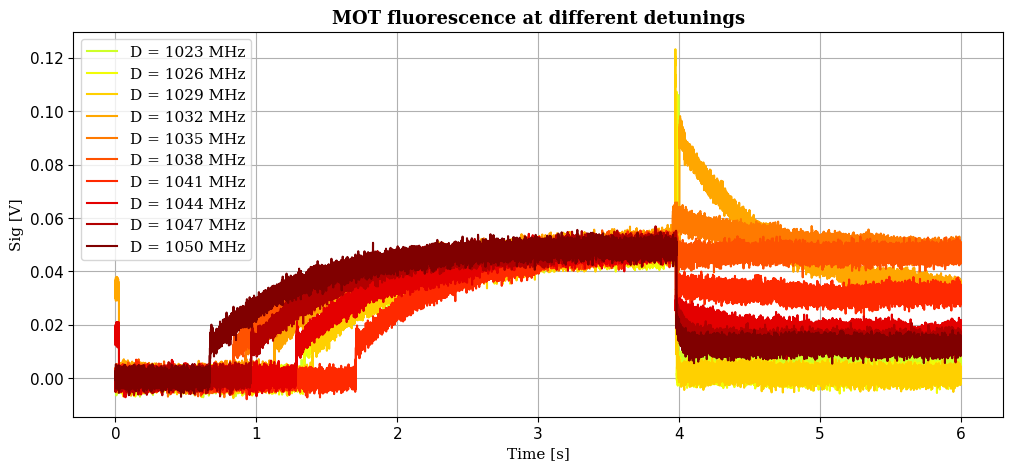

In [20]:
SAVE_DATA = True

DATASETS = []
DATA_RAW = []
directory = Path('.')

D_vals = (#1011, 1014, 1017,1020,
          1023, 1026, 1029,
          1032, 1035, 1038,
          1041, 1044, 1047, 1050) # MHz

color_palette = plt.cm.jet(np.linspace(0.6, 1, len(D_vals)))

_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.set_title(f'MOT fluorescence at different detunings', fontdict=title_font)

for i, D in enumerate(D_vals):
  file_list = list(directory.glob(f"B=5_D={D}.csv"))
  df = pd.read_csv(file_list[0], header=1, names=['Time [s]', 'Sig [V]'])
  DATASETS.append(df)
  
  x_data = df['Time [s]'].to_numpy()
  x_data = x_data - np.min(x_data)
  index_offset = (x_data > 0.2) * (x_data < 0.5)
  y_data = df['Sig [V]'].to_numpy()
  offset = np.mean(y_data[index_offset])
  y_data = y_data - offset

  DATA_RAW.append((x_data, y_data))
  
  N = len(x_data)
  ax.plot(x_data, y_data, label=f'D = {D} MHz', color=color_palette[i])
  ax.set_xlabel('Time [s]', fontdict=base_font)
  ax.set_ylabel('Sig [V]', fontdict=base_font)

plt.legend(prop=base_font)
plt.grid()
plt.show()

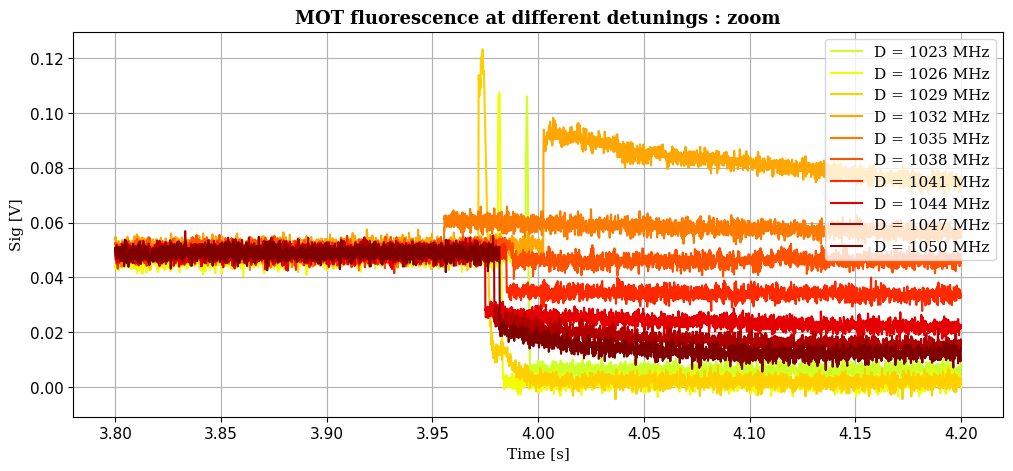

In [21]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.set_title(f'MOT fluorescence at different detunings : zoom', fontdict=title_font)

for i, D in enumerate(D_vals):
  x_data = DATA_RAW[i][0]
  y_data = DATA_RAW[i][1]
  
  index_to_plot = (x_data > 3.8) * (x_data < 4.2)
  ax.plot(x_data[index_to_plot], y_data[index_to_plot], label=f'D = {D} MHz', color=color_palette[i])
  ax.set_xlabel('Time [s]', fontdict=base_font)
  ax.set_ylabel('Sig [V]', fontdict=base_font)

plt.legend(prop=base_font)
plt.grid()
plt.show()

## Select data

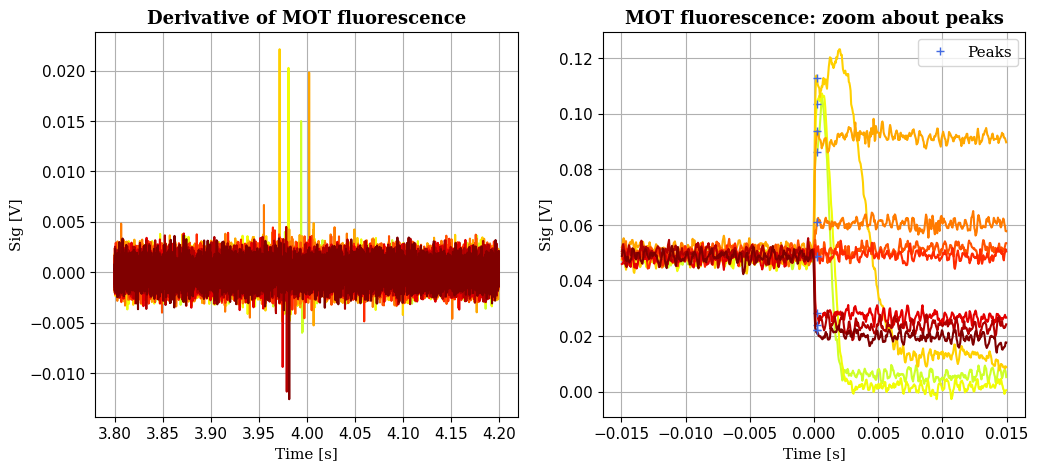

In [31]:
PHOTOEMISSION_VALS = []

_, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].set_title(f'Derivative of MOT fluorescence', fontdict=title_font)
ax[0].set_xlabel('Time [s]', fontdict=base_font)
ax[0].set_ylabel('Sig [V]', fontdict=base_font)
ax[0].grid()
  
ax[1].set_title(f'MOT fluorescence: zoom about peaks', fontdict=title_font)
ax[1].set_xlabel('Time [s]', fontdict=base_font)
ax[1].set_ylabel('Sig [V]', fontdict=base_font)
ax[1].grid()

for i, D in enumerate(D_vals):
  x_data = DATA_RAW[i][0]
  y_data = DATA_RAW[i][1]
  
  index_diff = (x_data > 3.8) * (x_data < 4.2)
  x_diff = x_data[index_diff][:-1]
  y_diff = np.diff(y_data[index_diff])
  y_data_diff = y_data[index_diff][:-1]
  
  ax[0].plot(x_diff, y_diff, label=f'D = {D} MHz', color=color_palette[i])  
  
  delta_time = 0.0003
  if D < 1042:
    # select data where diff is max
    index_photo = np.argmax(y_diff)
  else:
    # select data where diff is min
    index_photo = np.argmin(y_diff)

  x_photo = x_diff[index_photo]
  y_photo = y_diff[index_photo]
  
  index_interval = (x_data > x_photo - delta_time) * (x_data < x_photo + delta_time)
  x_interval = x_data[index_interval] - x_photo
  y_interval = y_data[index_interval]
  
  x_picked = x_interval[-2]
  y_picked = y_interval[-2]
  PHOTOEMISSION_VALS.append(y_picked)
  
  
  index_plot = (x_data > x_photo - 50*delta_time) * (x_data < x_photo + 50*delta_time)
  x_plot = x_data[index_plot] - x_photo
  y_plot = y_data[index_plot]
  
  ax[1].plot(x_plot, y_plot, color=color_palette[i])
  ax[1].plot([x_picked], [y_picked], '+', color='royalblue')

ax[1].plot([x_picked], [y_picked], '+', color='royalblue', label='Peaks')
plt.legend(prop=base_font)
plt.show()

if SAVE_DATA:
  df = pd.DataFrame({
    'BN_cooler [MHz]': D_vals,
    'PhotoEm [V]': PHOTOEMISSION_VALS
  })
  df.to_csv('/Photoemission_Data.csv')

## Fit Lorentzian

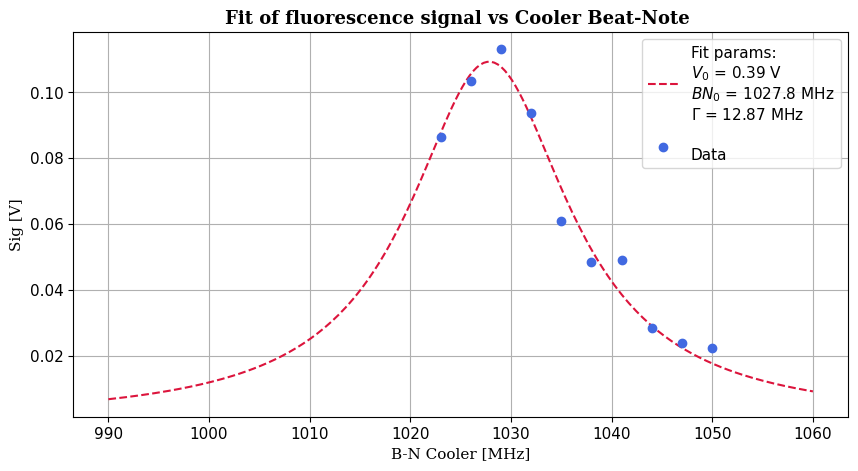

In [23]:
def Lorentzian_in_MOT(BN, V0, BN0, Gamma):
  s0 = 1.28
  return V0 * s0/2 / (1 + s0 + 4*(BN-BN0)**2 / Gamma**2)

x_data_fit = np.array(D_vals)
y_data_fit = np.array(PHOTOEMISSION_VALS)
popt, pcov = curve_fit(Lorentzian_in_MOT, x_data_fit, y_data_fit, p0=[1, 1027, 5])
V0, BN0, Gamma = popt
dV0, dBn0, dGamma = np.diag(pcov)

x_fit = np.linspace(990, 1060, 200)
y_fit = Lorentzian_in_MOT(x_fit, *popt)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(f'Fit of fluorescence signal vs Cooler Beat-Note ', fontdict=title_font)
ax.plot(x_fit, y_fit, '--', color='crimson', label='Fit params:\n'+r'$V_0$ = ' + f'{V0:.2f} V\n'+r'$BN_0$ = ' + f'{BN0:.1f} MHz\n'+r'$\Gamma$ = ' + f'{Gamma:.2f} MHz')
ax.plot(x_data_fit, y_data_fit, 'o', color='royalblue', label='\nData')
ax.set_xlabel(r'B-N Cooler [MHz]', fontdict=base_font)
ax.set_ylabel('Sig [V]', fontdict=base_font)
ax.grid()

plt.legend()
plt.show()

## Cooler intensity : $I = s_0 \cdot I_S$

In [24]:
Is = 1.67 # mW/cm^2
s0 = 1.28
print(f'MOT Cooler intensity = {s0 * Is :.2f} mW /cm^2')
print(f'Cooler intensity = {s0 * Is / 6 :.3f} mW /cm^2')

MOT Cooler intensity = 2.14 mW /cm^2
Cooler intensity = 0.356 mW /cm^2


In [25]:
def Prob_photoemission(Delta, s0, Gamma):
  return s0/2 / (1 + s0 + 4 * Delta**2 / Gamma**2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

def NumOfAtoms(V0, dV0, Delta, s0, Gamma):
  tau = 2.38 *1e6 # V/A 5% error
  eta = 0.5 # A/W 10 % error
  R_lens = 2 # cm
  dist_mot = 40 # cm
  sigma = np.pi * (R_lens/dist_mot)**2
  Gamma_fund = 5.88 * 1e6 # Hz
  Ep = 1.589 * 1.602 * 1e-19 # J
  
  I = V0 / tau # A
  P = I / eta # W
  
  # relative errors
  dV0_rel = dV0/V0
  dtau_rel = 0.05
  deta_rel = 0.1
  ddist_mot_rel = 2 / 40
  dsigma_rel = 2 * ddist_mot_rel
  
  Na = P / (sigma * Prob_photoemission(Delta, s0, Gamma) * Gamma_fund * Ep)
  dNa = (dV0_rel + dtau_rel + deta_rel + dsigma_rel) * Na
  
  return (Na, dNa)

In [26]:
Na, dNa = NumOfAtoms(V0=V0, dV0=dV0, Delta=0, s0=1.28, Gamma=Gamma)
print(f'Number of Atoms: ({Na/1e8:.2f} {pm} {dNa/1e8:.2f}) x 10^8')

Number of Atoms: (0.99 ± 0.25) x 10^8
